# 🚀 Project



### **Setup** ➡️ **Compare Models** ➡️ **Analyze Model** ➡️ **Prediction** ➡️ **Save Model**

In this step, the Wine Quality dataset (red wine) is loaded from the UCI Machine Learning Repository. The dataset includes various physicochemical properties of red wine samples along with their alcohol content, which serves as the target variable for regression analysis. Pandas is used to read the CSV file into a DataFrame and to perform an initial inspection of the data. Essential scikit-learn modules are also imported for later stages of preprocessing, train-test splitting, and modeling, including: train_test_split and KFold for splitting and cross-validation; StandardScaler and OneHotEncoder for scaling numeric features and encoding categorical ones; ColumnTransformer and Pipeline for building a clean preprocessing workflow; SimpleImputer for handling missing data; and LinearRegression as the baseline regression model. The df.head() function is then used to display the first few rows of the dataset to understand its structure.
<br/>

In [92]:
### load sample dataset
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib
from sklearn.linear_model import LinearRegression


red_df = pd.read_csv('winequality-red.csv', sep=';')


df = red_df
df.head()




,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Setup
The `setup` function initializes the training environment and creates the transformation pipeline.


The target variable for this regression task is `'alcohol'`.
`X` contains all features except the target, and `y` contains the target values.
This separates the dataset into predictors and response for modeling.


In [93]:
# regression and init setup
target = 'alcohol'
X = df.drop(columns=[target])
y = df[target]


Numeric and categorical features are identified so that appropriate preprocessing can be applied. Numeric features are imputed and scaled, while categorical features are imputed and one-hot encoded. A ColumnTransformer is then used to combine these preprocessing steps, and a Pipeline integrates the preprocessing stage with a Linear Regression model. Finally, the model is trained using the training set.

In [94]:

# Identify numeric & categorical features
numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Numeric pipeline: mean imputation + scaling
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: mode imputation + one-hot encoding
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Train/test split (like PyCaret setup)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

# Initialize regression model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'quality']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('regressor', LinearRegression())])

In [95]:
# check the type of exp
type(model)

sklearn.pipeline.Pipeline

In [96]:
# init setup on exp
y_pred = model.predict(X_test)


## Compare Models

A set of baseline regression models is defined to evaluate performance on the dataset. The models include Linear Regression, Ridge, Lasso, Random Forest, and Gradient Boosting. These models are later compared using cross-validation to identify the best-performing estimator.

In [97]:
# compare baseline models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Dictionary of models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=123),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=123)
}



In [98]:
# compare models using OOP
# exp.compare_models()
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

def compare_models(X, y, models, cv_splits=5, scoring='r2'):
    """Trains all models using cross-validation and returns a scoring grid"""
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=123)
    results = []

    for name, model in models.items():
        pipeline = Pipeline([
            ('preprocessor', preprocessor),  # preprocessing pipeline from setup
            ('regressor', model)
        ])
        scores = cross_val_score(pipeline, X, y, cv=kf, scoring=scoring)
        results.append({
            "Model": name,
            "Mean Score": np.mean(scores),
            "Std Score": np.std(scores)
        })

    return pd.DataFrame(results).sort_values(by="Mean Score", ascending=False)
# Compare all baseline regressors
results_df = compare_models(X, y, models)
results_df



,Model,Mean Score,Std Score
3,Random Forest,0.760760,0.031263
4,Gradient Boosting,0.752817,0.024694
1,Ridge,0.681951,0.040491
0,Linear Regression,0.681936,0.040671
2,Lasso,0.490356,0.030671


In [82]:
# Create a Random Forest model
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=123))
])

# Fit on training data
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Model -> RMSE: {rmse:.3f}, R2: {r2:.3f}")


Random Forest Model -> RMSE: 0.510, R2: 0.769


Notice that the output between functional and OOP API is consistent. Rest of the functions in this notebook will only be shown using functional API only.

___

## Analyze Model
The best-performing model (Random Forest) is trained on the training set, with the preprocessing pipeline applied to ensure consistent feature transformation. Predictions are generated for the test set, and residuals (the differences between actual and predicted values) are calculated. The resulting residual plot visualizes these differences, helping assess model performance, reveal potential patterns or bias, and determine whether errors are randomly distributed an important aspect of regression diagnostics.

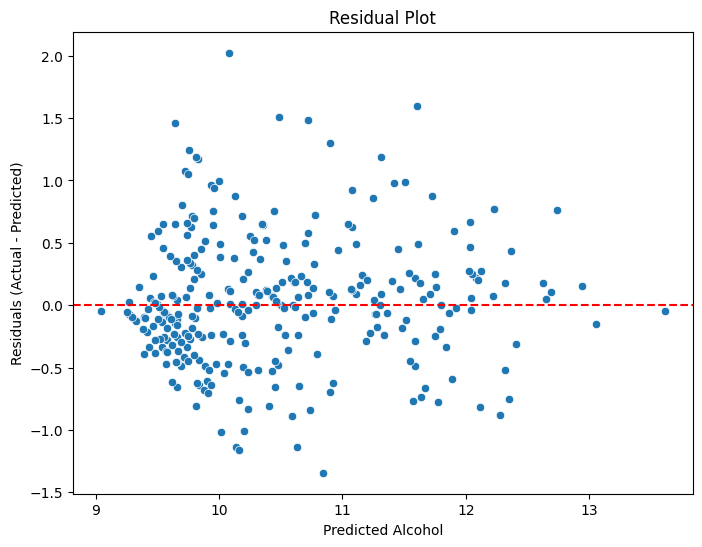

In [99]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pipeline: preprocessing + regressor
best = Pipeline([
    ('preprocessor', preprocessor),  # preprocessing pipeline
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=123))
])

# Fit on training data
best.fit(X_train, y_train)

# Make predictions on test set
y_pred = best.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Alcohol')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()




A visualization is created to show how closely the model’s predictions match the actual target values. A scatter plot of predicted vs. actual alcohol values is displayed, along with a diagonal line representing perfect predictions. Points that fall close to the diagonal indicate accurate predictions, while points farther away highlight errors or variability in the model’s performance.

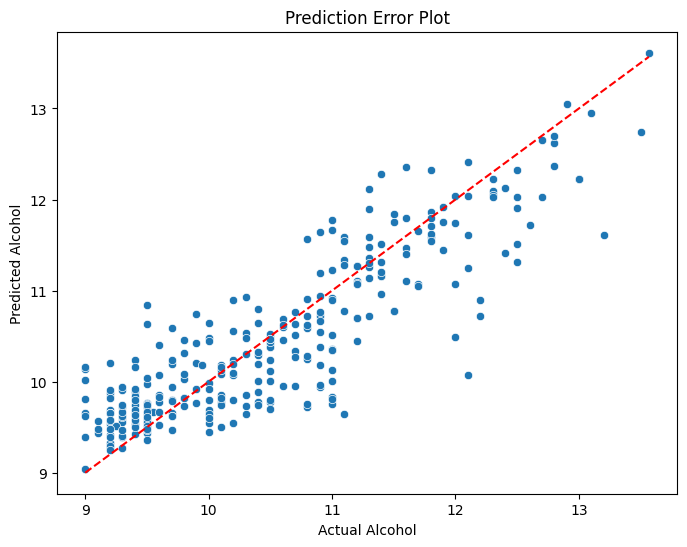

In [100]:
# plot error
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on test set (if not already done)
y_pred = best.predict(X_test)

# Ensure y_test is a pandas Series (in case it's a numpy array)
y_test_series = pd.Series(y_test.values, index=y_test.index)

# Plot Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_series, y=y_pred)
plt.plot([y_test_series.min(), y_test_series.max()],
         [y_test_series.min(), y_test_series.max()], 'r--')  # perfect prediction line
plt.xlabel('Actual Alcohol')
plt.ylabel('Predicted Alcohol')
plt.title('Prediction Error Plot')
plt.show()


The analysis evaluates which features contribute most to the model’s predictions. For tree-based models such as Random Forest, the feature_importances_ attribute is used to rank features by their impact. For linear models, coefficients are examined to assess the influence of each feature. A bar plot then visualizes the relative importance or magnitude of these features, providing insight into what drives alcohol content in the wine dataset.

/tmp/ipython-input-57471206.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')


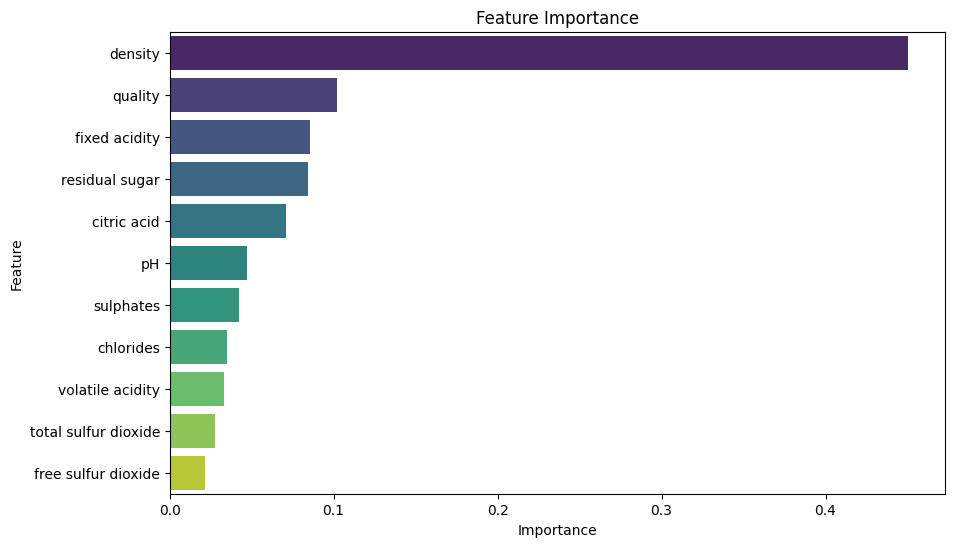

In [101]:
# plot feature importance
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Check if model supports feature_importances_ (tree-based models)
regressor = best.named_steps['regressor']  # extract the actual regressor

if hasattr(regressor, 'feature_importances_'):
    importances = regressor.feature_importances_

    # Only numeric features in wine dataset
    feature_names = numeric_features

    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')
    plt.title('Feature Importance')
    plt.show()

# For linear models, use coefficients
elif hasattr(regressor, 'coef_'):
    coef = regressor.coef_
    feature_names = numeric_features  # Only numeric features

    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coef
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(data=feat_imp_df, x='Coefficient', y='Feature', palette='viridis')
    plt.title('Model Coefficients (Feature Importance)')
    plt.show()

else:
    print("This model does not support feature importance or coefficients.")


In [102]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Make predictions on test set
y_pred = best.predict(X_test)

# Compute metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # compute RMSE manually
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print("Model Evaluation Metrics:")
print(f"RMSE : {rmse:.3f}")
print(f"MSE  : {mse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"R2   : {r2:.3f}")



Model Evaluation Metrics:
RMSE : 0.510
MSE  : 0.260
MAE  : 0.379
R2   : 0.769


## Prediction
A copy of the test set features is created to store the model’s predictions. The trained pipeline is then used to predict alcohol content for each sample in the test set. This enables a comparison between predicted and actual values to evaluate model performance.

In [103]:
# predict on test set

holdout_pred = X_test.copy()





In [104]:


# Show first 5 rows
holdout_pred.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality
912,10.0,0.46,0.44,2.9,0.065,4.0,8.0,0.99674,3.33,0.62,6
772,9.5,0.57,0.27,2.3,0.082,23.0,144.0,0.99782,3.27,0.55,5
1037,7.3,0.91,0.10,1.8,0.074,20.0,56.0,0.99672,3.35,0.56,5
1106,8.2,0.23,0.42,1.9,0.069,9.0,17.0,0.99376,3.21,0.54,6
263,7.9,0.37,0.23,1.8,0.077,23.0,49.0,0.99630,3.28,0.67,5


A new dataset is created by dropping the target column (alcohol) from the original data. The trained model is then used to predict alcohol content for these samples. The predicted values are added as a new column (alcohol_pred) to the dataset for further analysis or reporting.

In [105]:

# Copy original data and drop target column
new_data = df.drop(columns=['alcohol']).copy()

# Predict alcohol using trained model
predictions = new_data.copy()
predictions['alcohol_pred'] = best.predict(new_data)

# Show first 5 rows
predictions.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality,alcohol_pred
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,5,9.416
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,5,9.691
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,5,9.739
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,6,10.011
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,5,9.416


___

## Save Model

The entire trained pipeline, including preprocessing steps and the regression model, is saved to disk using joblib. This allows the pipeline to be reused later for predictions without retraining. The pipeline is stored as 'my_first_pipeline.pkl' and can be loaded at any time for inference.

In [106]:
# Save pipeline
pipeline_filename = "my_first_pipeline.pkl"
joblib.dump(best, pipeline_filename)

print(f"Pipeline saved to '{pipeline_filename}'")



Pipeline saved to 'my_first_pipeline.pkl'


In [107]:
# load pipeline
loaded_best_pipeline = joblib.load(pipeline_filename)
y_pred_loaded = loaded_best_pipeline.predict(X_test)
print("Loaded pipeline predictions (first 5):", y_pred_loaded[:5])

Loaded pipeline predictions (first 5): [10.898  9.513  9.69  12.084  9.905]
